In [1]:
import operator
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from utils.analysis_utils import get_data
#from utils.learning_utils import pickle_load, pickle_save, get_strategy_counts, get_cluster_dict, get_modified_weights, \
#                            get_normalized_features, create_dir
from utils import learning_utils, distributions
sys.modules["learning_utils"] = learning_utils
sys.modules["distributions"] = distributions
from planning_strategies import strategy_dict
from rl_models import models as rl_models
import seaborn as sns
from computational_microscope import ComputationalMicroscope
from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare
from scipy.stats import ttest_ind, pearsonr
from IPython.core.display import display, HTML
from utils.experiment_utils import Experiment
from utils.result_utils import *
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["axes.grid"] = False

/Users/rhe/PycharmProjects/ComputationalMicroscope/venv/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


### TODO:
2. Unique strategies and strategy percentages

In [2]:
features = pickle_load("data/microscope_features.pkl")
exp_pipelines = pickle_load("data/exp_pipelines.pkl")
exp_reward_structures = {'v1.0': 'high_increasing', 'F1': 'high_increasing', 'c1.1': 'low_constant', 'T1.1': 'large_increasing'}
num_features = len(features)

In [3]:
features = pickle_load("data/microscope_features.pkl")

decision_systems = pickle_load("data/decision_systems.pkl")
feature_systems = pickle_load("data/feature_systems.pkl")
decision_system_features = pickle_load("data/decision_system_features.pkl")

W_DS = pickle_load("data/strategy_decision_weights.pkl")
DS_proportions = pickle_load("data/strategy_decision_proportions.pkl")

strategy_weights = pickle_load("data/microscope_weights.pkl")

L1_DS = pickle_load("data/L1_DS.pkl")
L2_DS = pickle_load("data/L2_DS.pkl")
L1_norm_DS = pickle_load("data/L1_norm_DS.pkl")
L2_norm_DS = pickle_load("data/L2_norm_DS.pkl")

L1_distances = pickle_load("data/L1_distances.pkl")
L2_distances = pickle_load("data/L2_distances.pkl")
jeffreys_divergence = pickle_load("data/jeffreys_divergences.pkl")
jsd = pickle_load("data/js_divergences.pkl")

strategy_space = pickle_load("data/strategy_space.pkl")
num_strategies = len(strategy_space)
strategy_feature_scores = pickle_load("data/strategy_feature_scores.pkl") # Average scores using feature based representation of the strategies
strategy_scores = pickle_load("data/strategy_scores.pkl") # Average scores using an algorithmic representation of the strategies

clusters = pickle_load("data/kl_clusters.pkl")
cluster_map = pickle_load("data/kl_cluster_map.pkl")

cluster_scores = pickle_load("data/cluster_scores.pkl")
cluster_names = pickle_load("data/cluster_names.pkl")

In [4]:
def get_E(exp_num, increasing=False, condition='', block=''):
    pids = None
    if exp_num == "T1.1":
        block = 'test'
    exp_data = get_data(exp_num)
    participants_df = exp_data['participants']
    if 'pids' in exp_data:
        pids = sorted(exp_data['pids']['pids'].tolist())
    else:
        pids = participants_df['pid'].tolist()
    trials_data = exp_data['mouselab-mdp']
    participant_conditions = {}
    if exp_num in ["c1.1", "c2.1"]:
        trials_data = trials_data[trials_data.block == "test"]
        if exp_num in "c2.1":
            conditions = participants_df[['pid', 'variance']]
            conditions.set_index('pid', inplace = True)
            participant_conditions = conditions.to_dict()['variance']
            increasing_pids = [pid for pid in participant_conditions.keys() if participant_conditions[pid] == 2424 and pid in pids]
            decreasing_pids = [pid for pid in participant_conditions.keys() if participant_conditions[pid] == 2442 and pid in pids]
    if not exp_num == "c2.1":
            pipeline = exp_pipelines[exp_num]
            reward_structure = exp_reward_structures[exp_num]
    else:
        if increasing:
            pipeline = exp_pipelines["c2.1_inc"]
            pids = increasing_pids
            reward_structure = 'high_increasing'
        else:
            pipeline = exp_pipelines["c2.1_dec"]
            pids = decreasing_pids
            reward_structure = 'high_decreasing'

    if condition or block:
        suffix = block + "_" + condition
    else:
        suffix = ""
    normalized_features = get_normalized_features(reward_structure)
    W = learning_utils.get_modified_weights(strategy_space, strategy_weights)
    pipeline = [pipeline[0]]*100
    cm = ComputationalMicroscope(pipeline, strategy_space, W, features, normalized_features=normalized_features)
    if condition:
        if exp_num == "v1.0":
            E = Experiment(exp_num, cm=cm, pids = pids, feedback=condition)
            if block:
                E = Experiment(exp_num, cm=cm, pids=pids, feedback=condition, block=block)
        else:
            E = Experiment(exp_num, cm=cm, pids=pids, condition=condition)
    else:
        E = Experiment(exp_num, cm=cm, pids=pids)
        if block:
            E = Experiment(exp_num, cm=cm, block=block, pids=pids)
    if block and not exp_num == "c2.1":
        try:
            strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_{block}_strategies.pkl")
        except Exception as e:
            print(e)
            return E, _, normalized_features, cm
    else:
        if exp_num == "c2.1":
            if increasing:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_inc_strategies.pkl")
                if block:
                    strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_inc_{block}_strategies.pkl")
                
            else:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_dec_strategies.pkl")
                if block:
                    strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_dec_{block}_strategies.pkl")
        else:
            try:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_strategies.pkl")
            except:
                strategies = None
    return E, strategies, normalized_features

In [5]:
def bayesfactor(f, s):
    data = []
    for i in f:
        data.append([i, "f"])
    for i in s:
        data.append([i, "s"])
    df = pd.DataFrame(data, columns=["count", "condition"])
    robjects.globalenv["x"] = df
    ttest_output = r('print(t.test(count ~ condition, data = x, var.eq = TRUE, alternative="less"))')
    ttest_output = r('print(t.test(count ~ condition, data = x, var.eq = TRUE, alternative="greater"))')
    bf = r('print(ttestBF(formula=count ~ condition, data = x, nullInterval = c(0, Inf)))')

### Validation

In [6]:
from utils.result_utils import get_standard_error, get_confusion, get_accuracy, get_confusions, get_proportion_confusion, get_proportion_se

In [7]:
strategy_validation_sequences = pickle_load("data/strategy_validation_sequences.pkl")
models = ["random", "random_switch", "gradual", "mixed", "bernoulli_rssl"]
distance = "L2_W"
num_seq = 500
TRUE_S = []
INFERRED_S = []
print("Model-wise Accuracy: ")
for model in models:
    total_accs = []
    true_s = []
    inferred_s = []
    for i in range(num_seq):
        acc, data = strategy_validation_sequences[model][distance][i]
        strategy_validation_sequences[model][distance].append((acc, data))
        true = data[0]['s']
        inferred = data[0]['inferred']
        total_accs.append(acc)
        true_s += true
        inferred_s += inferred
        TRUE_S += true
        INFERRED_S += inferred
    num_trials = len(inferred_s)
    strategy_confusion, cluster_confusion = get_confusions(true_s, inferred_s, cluster_map)
    proportion_strategy_confusion = get_proportion_confusion(strategy_confusion, strategy_space)
    proportion_cluster_confusion = get_proportion_confusion(cluster_confusion, range(1, len(clusters)+1))
    print(model)
    acc = get_accuracy(strategy_confusion)
    se = np.round(1.96*get_proportion_se(acc, num_trials), 3)
    print("Strategy Accuracy: ", acc, "± ", se)
    acc = get_accuracy(cluster_confusion)
    se = np.round(1.96*get_proportion_se(acc, num_trials), 3)
    print("Cluster Accuracy: ", acc, "± ", se, "\n")
    
print("Overall Accuracy: ")
strategy_confusion, cluster_confusion = get_confusions(TRUE_S, INFERRED_S, cluster_map)
proportion_strategy_confusion = get_proportion_confusion(strategy_confusion, strategy_space)
proportion_cluster_confusion = get_proportion_confusion(cluster_confusion, range(1, len(clusters)+1))

acc = get_accuracy(strategy_confusion)
se = np.round(1.96*get_proportion_se(acc, num_trials), 3)
print("Strategy Accuracy: ", acc, "± ", se)
acc = get_accuracy(cluster_confusion)
se = np.round(1.96*get_proportion_se(acc, num_trials), 3)
print("Cluster Accuracy: ", acc, "± ", se, "\n")

Model-wise Accuracy: 
random
Strategy Accuracy:  0.757 ±  0.007
Cluster Accuracy:  0.909 ±  0.005 

random_switch
Strategy Accuracy:  0.88 ±  0.005
Cluster Accuracy:  0.962 ±  0.003 

gradual
Strategy Accuracy:  0.769 ±  0.007
Cluster Accuracy:  0.912 ±  0.004 

mixed
Strategy Accuracy:  0.823 ±  0.006
Cluster Accuracy:  0.935 ±  0.004 

bernoulli_rssl
Strategy Accuracy:  0.755 ±  0.007
Cluster Accuracy:  0.904 ±  0.005 

Overall Accuracy: 
Strategy Accuracy:  0.797 ±  0.006
Cluster Accuracy:  0.924 ±  0.004 



### Empericial analyses

In [8]:
F1, F1_strategies, _ = get_E("F1")
v1, v1_strategies, _ = get_E("v1.0")
c1, c1_strategies, _ = get_E("c1.1", block='test')
c2_inc, c2_inc_strategies, _ = get_E("c2.1", increasing=True, block='test')
c2_dec, c2_dec_strategies, _ = get_E("c2.1", increasing=False, block='test')
T1, T1_strategies, _ = get_E("T1.1", block='test')

In [9]:
v1_meta, v1_meta_strategies, _ = get_E("v1.0", condition='meta')
v1_meta.infer_strategies(precomputed_strategies=v1_meta_strategies, show_pids=False)
v1_action, v1_action_strategies, _ = get_E("v1.0", condition='action')
v1_action.infer_strategies(precomputed_strategies=v1_meta_strategies, show_pids=False)
v1_nofb, v1_nofb_strategies, _ = get_E("v1.0", condition='none')
v1_nofb.infer_strategies(precomputed_strategies=v1_meta_strategies, show_pids=False)

HERE 1 feedback
HERE 2 meta
     pid  bonus  completed                                          startTime  \
0      0   1.56       True  Fri Mar 08 2019 14:53:42 GMT-0600 (Central Sta...   
1      1   1.77       True  Fri Mar 08 2019 14:47:02 GMT-0600 (Central Sta...   
2      2   0.26       True  Fri Mar 08 2019 14:40:03 GMT-0600 (Central Sta...   
3      3   1.05       True  Fri Mar 08 2019 11:51:48 GMT-0800 (Pacific Sta...   
4      4   1.82       True  Fri Mar 08 2019 15:32:29 GMT-0500 (Eastern Sta...   
..   ...    ...        ...                                                ...   
175  175   1.63       True  Fri Mar 08 2019 13:52:32 GMT-0500 (Eastern Sta...   
176  176   0.38       True  Fri Mar 08 2019 14:35:20 GMT-0600 (Central Sta...   
177  177   1.55       True  Fri Mar 08 2019 15:36:17 GMT-0500 (Eastern Sta...   
178  178   1.71       True  Fri Mar 08 2019 14:25:22 GMT-0700 (Mountain St...   
179  179   1.67       True  Fri Mar 08 2019 15:39:43 GMT-0500 (Eastern Sta...   


HERE 1 feedback
HERE 2 action
     pid  bonus  completed                                          startTime  \
0      0   1.56       True  Fri Mar 08 2019 14:53:42 GMT-0600 (Central Sta...   
1      1   1.77       True  Fri Mar 08 2019 14:47:02 GMT-0600 (Central Sta...   
2      2   0.26       True  Fri Mar 08 2019 14:40:03 GMT-0600 (Central Sta...   
3      3   1.05       True  Fri Mar 08 2019 11:51:48 GMT-0800 (Pacific Sta...   
4      4   1.82       True  Fri Mar 08 2019 15:32:29 GMT-0500 (Eastern Sta...   
..   ...    ...        ...                                                ...   
175  175   1.63       True  Fri Mar 08 2019 13:52:32 GMT-0500 (Eastern Sta...   
176  176   0.38       True  Fri Mar 08 2019 14:35:20 GMT-0600 (Central Sta...   
177  177   1.55       True  Fri Mar 08 2019 15:36:17 GMT-0500 (Eastern Sta...   
178  178   1.71       True  Fri Mar 08 2019 14:25:22 GMT-0700 (Mountain St...   
179  179   1.67       True  Fri Mar 08 2019 15:39:43 GMT-0500 (Eastern Sta...  

HERE 1 feedback
HERE 2 none
     pid  bonus  completed                                          startTime  \
0      0   1.56       True  Fri Mar 08 2019 14:53:42 GMT-0600 (Central Sta...   
1      1   1.77       True  Fri Mar 08 2019 14:47:02 GMT-0600 (Central Sta...   
2      2   0.26       True  Fri Mar 08 2019 14:40:03 GMT-0600 (Central Sta...   
3      3   1.05       True  Fri Mar 08 2019 11:51:48 GMT-0800 (Pacific Sta...   
4      4   1.82       True  Fri Mar 08 2019 15:32:29 GMT-0500 (Eastern Sta...   
..   ...    ...        ...                                                ...   
175  175   1.63       True  Fri Mar 08 2019 13:52:32 GMT-0500 (Eastern Sta...   
176  176   0.38       True  Fri Mar 08 2019 14:35:20 GMT-0600 (Central Sta...   
177  177   1.55       True  Fri Mar 08 2019 15:36:17 GMT-0500 (Eastern Sta...   
178  178   1.71       True  Fri Mar 08 2019 14:25:22 GMT-0700 (Mountain St...   
179  179   1.67       True  Fri Mar 08 2019 15:39:43 GMT-0500 (Eastern Sta...   


In [10]:
normalized_features = get_normalized_features("high_increasing")

In [11]:
for E in [v1_meta, v1_action, v1_nofb]:
    E.init_feature_properties(features, normalized_features, strategy_weights)
    E.init_decision_system_properties(decision_systems, W_DS, DS_proportions)

### Section 2.2.2

In [12]:
from sequence_utils import get_acls, summarize_acl

In [13]:
exps = ["v1.0", "c1.1", "c2.1_dec", "T1.1"]
ps = ["high_increasing", "low_constant", "high_decreasing", "large_increasing"]
Es = [v1, c1, c2_dec, T1]
Ss = [v1_strategies, c1_strategies, c2_dec_strategies, T1_strategies]
for i in range(len(exps)):
    print(exps[i])
    reward_structure = ps[i]
    normalized_features = get_normalized_features(reward_structure)
    exp = Es[i]
    strategies = Ss[i]
    acls, random_acls = get_acls(strategies, exp.pids, exp.planning_data['envs'], exp.planning_data['clicks'], exp_pipelines[exps[i]], features, normalized_features, strategy_weights)
    summarize_acl(v1_strategies, acls, random_acls, 30)

v1.0
Mean of average click likelihoods is  0.37348354052563976
Mean of random average click likelihoods is  0.09606220613989894
c1.1
Mean of average click likelihoods is  0.3280536350020796
Mean of random average click likelihoods is  0.09224762918365909
c2.1_dec
Mean of average click likelihoods is  0.25876760863691484
Mean of random average click likelihoods is  0.08642677880000138
T1.1
Mean of average click likelihoods is  0.18675514727058123
Mean of random average click likelihoods is  0.03477499826717032


### Section 2.2.3

### Self-transitions

In [14]:
v_uniform , _, _= get_E("v1.0")
uniform_strategies = pickle_load("results/uniform_prior_inferences/v1.0_strategies.pkl")
v_uniform.infer_strategies(precomputed_strategies=uniform_strategies, show_pids = False)
transition_frequencies = v_uniform.get_transition_frequencies()

Strategies for 28 not found. Skipping adding strategy data
Strategies for 45 not found. Skipping adding strategy data
Strategies for 89 not found. Skipping adding strategy data
Strategies for 95 not found. Skipping adding strategy data
Strategies for 97 not found. Skipping adding strategy data
Strategies for 104 not found. Skipping adding strategy data
Strategies for 107 not found. Skipping adding strategy data
Strategies for 150 not found. Skipping adding strategy data


In [15]:
self_transition_counts = []
transition_counts = []
for tr, k in transition_frequencies.items():
    if tr[0] != tr[1]:
        transition_counts.append(k)
    else:
        self_transition_counts.append(k)
print(len(self_transition_counts), len(transition_counts))

56 921


In [16]:
print(bayesfactor(self_transition_counts, transition_counts))



	Two Sample t-test




data:  

count by condition



t = 7.553, df = 975, p-value = 1


alternative hypothesis: 
true 

difference in means

 is 

less than

 

0



95

 percent confidence interval:


 

    -Inf 28.40307



sample estimates:

mean in group f 
mean in group s 


      26.821429 
       3.501629 






	Two Sample t-test




data:  

count by condition



t = 7.553, df = 975, p-value = 4.883e-14


alternative hypothesis: 
true 

difference in means

 is 

greater than

 

0



95

 percent confidence interval:


 

18.23653      Inf



sample estimates:

mean in group f 
mean in group s 


      26.821429 
       3.501629 






/Users/rhe/PycharmProjects/ComputationalMicroscope/venv/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in ttestBF(formula = count ~ condition, data = x, nullInterval = c(0,  : 
  konnte Funktion "ttestBF" nicht finden

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Fehler in ttestBF(formula = count ~ condition, data = x, nullInterval = c(0,  : 
  konnte Funktion "ttestBF" nicht finden


### Section 4.2.1

In [17]:
from scipy.stats import wilcoxon
from learning_utils import sidak_value
conditions = ["MCFB", "Action FB", "No FB"]
exps = [v1_meta, v1_action, v1_nofb]
num_comparisons = 3*5
alpha_sidak = np.round(sidak_value(0.05, num_comparisons), 4)
print("Alpha: ", alpha_sidak)
for exp, condition in zip(exps, conditions):
    print("\n")
    DSW = exp.get_DSW()
    DSW = np.array(DSW)
    k = 5
    for i in range(DSW.shape[-1]):
        x1 = np.mean(DSW[:, :1, i], axis=1)
        x2 = np.mean(DSW[:, -10:, i], axis=1)
        T, p = wilcoxon(x1, x2)
        if p < alpha_sidak:
            print(condition, decision_systems[i], T, np.round(p, 4))
            t_test(x1, x2)

Alpha:  0.0034


MCFB mental_effort_avoidance 1.0 0.0001
t(108): 2.81, p: 0.006
MCFB model-based_metareasoning 248.0 0.0005
t(108): -1.11, p: 0.2701
MCFB pavlovian 276.0 0.0008
t(108): -2.76, p: 0.0068
MCFB satisficing_and_stopping 82.0 0.0
t(108): -7.45, p: 0.0


Action FB model-free_values_and_heuristics 229.0 0.0004
t(106): 3.85, p: 0.0002
Action FB pavlovian 183.0 0.0005
t(106): -3.61, p: 0.0005
Action FB satisficing_and_stopping 134.0 0.0001
t(106): -3.96, p: 0.0001


No FB model-based_metareasoning 206.0 0.0012
t(106): -1.66, p: 0.099
No FB pavlovian 148.0 0.0
t(106): -5.01, p: 0.0
No FB satisficing_and_stopping 173.0 0.0002
t(106): -3.91, p: 0.0002


### Trajectories

In [18]:
c_nofb_trs, c_nofb_sorted_counts = get_cluster_trajectories(v1_nofb)
c_meta_trs, c_meta_sorted_counts = get_cluster_trajectories(v1_meta)
c_action_trs, c_action_sorted_counts = get_cluster_trajectories(v1_action)
c_nofb_ls = get_lengths(c_nofb_trs)
c_meta_ls = get_lengths(c_meta_trs)
c_action_ls = get_lengths(c_action_trs)

1.9259259259259258
0.8727272727272727
2.7037037037037037


In [19]:
# MCFB vs No FB
bayesfactor(c_meta_ls, c_nofb_ls)

# MCFB vs Action FB
bayesfactor(c_meta_ls, c_action_ls)

# Action vs No FB
bayesfactor(c_action_ls, c_nofb_ls)



	Two Sample t-test




data:  

count by condition



t = -2.6463, df = 107, p-value = 0.004683


alternative hypothesis: 
true 

difference in means

 is 

less than

 

0



95

 percent confidence interval:


 

      -Inf -0.3928399



sample estimates:

mean in group f 
mean in group s 


      0.8727273 
      1.9259259 






	Two Sample t-test




data:  

count by condition



t = -2.6463, df = 107, p-value = 0.9953


alternative hypothesis: 
true 

difference in means

 is 

greater than

 

0



95

 percent confidence interval:


 

-1.713557       Inf



sample estimates:

mean in group f 
mean in group s 


      0.8727273 
      1.9259259 






RRuntimeError: Fehler in ttestBF(formula = count ~ condition, data = x, nullInterval = c(0,  : 
  konnte Funktion "ttestBF" nicht finden


### Strategy frequencies

In [20]:
def prop_test(x, N):
    data = []
    data += [["MCFB", "Optimal"]]*x[0]
    data += [["MCFB", "Sub-optimal"]]*int((N[0]-x[0]))
    data += [["NFB", "Optimal"]]*x[1]
    data += [["NFB", "Sub-optimal"]]*int((N[1]-x[1]))
    df = pd.DataFrame(data, columns=["FB", "Strategy"])
    robjects.globalenv["x"] = df
    x_vector = robjects.IntVector(x)
    N_vector = robjects.IntVector(N)
    test = robjects.r('prop.test')
    #print(test(x_vector, N_vector, correct=True))
    r('print(chisq.test(x$FB, x$Strategy))')
    crosstab = r('xtabs(~FB + Strategy, x)')
    robjects.globalenv["crosstab"] = crosstab
    r('print(contingencyTableBF(crosstab, sampleType = "indepMulti", fixedMargin="cols", correct=FALSE))')

In [21]:
from scipy.stats import chi2_contingency
conditions = ['Metacognitive FB', 'Action FB', 'No FB']
forward_planning_strategies = [3, 10, 82, 5, 36, 37, 54, 79, 22, 23, 32, 33, 53, 64, 65, 69, 70, 80, 28, 34]
goal_setting_strategies = [21]
forward_freqs = {}
goal_setting_freqs = {}
total = {}
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    s_freqs, total_f = exp.get_strategy_frequencies(exp.participant_strategies, trial_wise=True)
    forward_freqs[conditions[i]] = np.sum([[s_freqs[t].get(s, 0) for t in s_freqs.keys()] for s in forward_planning_strategies], axis=0)
    goal_setting_freqs[conditions[i]] = np.sum([[s_freqs[t].get(s, 0) for t in s_freqs.keys()] for s in goal_setting_strategies], axis=0)
    total[conditions[i]] = total_f
    
z, p = proportions_ztest([np.sum(goal_setting_freqs[conditions[0]]), np.sum(goal_setting_freqs[conditions[2]])], nobs=[np.sum(total[conditions[0]]), np.sum(total[conditions[2]])])
prop_test([np.sum(goal_setting_freqs[conditions[0]]), np.sum(goal_setting_freqs[conditions[2]])], [np.sum(total[conditions[0]]), np.sum(total[conditions[2]])])
print(z, p)

z, p = proportions_ztest([np.sum(goal_setting_freqs[conditions[1]]), np.sum(goal_setting_freqs[conditions[2]])], nobs=[np.sum(total[conditions[1]]), np.sum(total[conditions[2]])])
prop_test([np.sum(goal_setting_freqs[conditions[1]]), np.sum(goal_setting_freqs[conditions[2]])], [np.sum(total[conditions[1]]), np.sum(total[conditions[2]])])
print(z, p)

z, p = proportions_ztest([np.sum(forward_freqs[conditions[0]]), np.sum(forward_freqs[conditions[2]])], nobs=[np.sum(total[conditions[0]]), np.sum(total[conditions[2]])])
prop_test([np.sum(forward_freqs[conditions[0]]), np.sum(forward_freqs[conditions[2]])], [np.sum(total[conditions[0]]), np.sum(total[conditions[2]])])
print(z, p)

z, p = proportions_ztest([np.sum(forward_freqs[conditions[1]]), np.sum(forward_freqs[conditions[2]])], nobs=[np.sum(total[conditions[1]]), np.sum(total[conditions[2]])])
prop_test([np.sum(forward_freqs[conditions[1]]), np.sum(forward_freqs[conditions[2]])], [np.sum(total[conditions[1]]), np.sum(total[conditions[2]])])
print(z, p)



	Pearson's Chi-squared test with Yates' continuity correction




data:  

x$FB and x$Strategy



X-squared = 238.28, df = 1, p-value < 2.2e-16






/Users/rhe/PycharmProjects/ComputationalMicroscope/venv/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in contingencyTableBF(crosstab, sampleType = "indepMulti", fixedMargin = "cols",  : 
  konnte Funktion "contingencyTableBF" nicht finden

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Fehler in contingencyTableBF(crosstab, sampleType = "indepMulti", fixedMargin = "cols",  : 
  konnte Funktion "contingencyTableBF" nicht finden


### Figure 6

In [22]:
v1, v1_strategies, _ = get_E("v1.0")
v1.infer_strategies(precomputed_strategies=v1_strategies, show_pids=False)

Strategies for 7 not found. Skipping adding strategy data
Strategies for 28 not found. Skipping adding strategy data
Strategies for 45 not found. Skipping adding strategy data
Strategies for 46 not found. Skipping adding strategy data
Strategies for 72 not found. Skipping adding strategy data
Strategies for 89 not found. Skipping adding strategy data
Strategies for 95 not found. Skipping adding strategy data
Strategies for 97 not found. Skipping adding strategy data
Strategies for 104 not found. Skipping adding strategy data
Strategies for 107 not found. Skipping adding strategy data
Strategies for 132 not found. Skipping adding strategy data
Strategies for 143 not found. Skipping adding strategy data
Strategies for 150 not found. Skipping adding strategy data


In [23]:
k = 6
best_c = set()
for i, exp in enumerate([v1]):
    exp.init_strategy_clusters(cluster_map)
    props = exp.get_cluster_proportions()
    sorted_props = sorted(props.items(), key=operator.itemgetter(1), reverse=True)
    for p in sorted_props[:k]:
        best_c.add(p[0])
best_c = sorted(list(best_c))
print(best_c)

[5, 7, 8, 9, 10, 13]


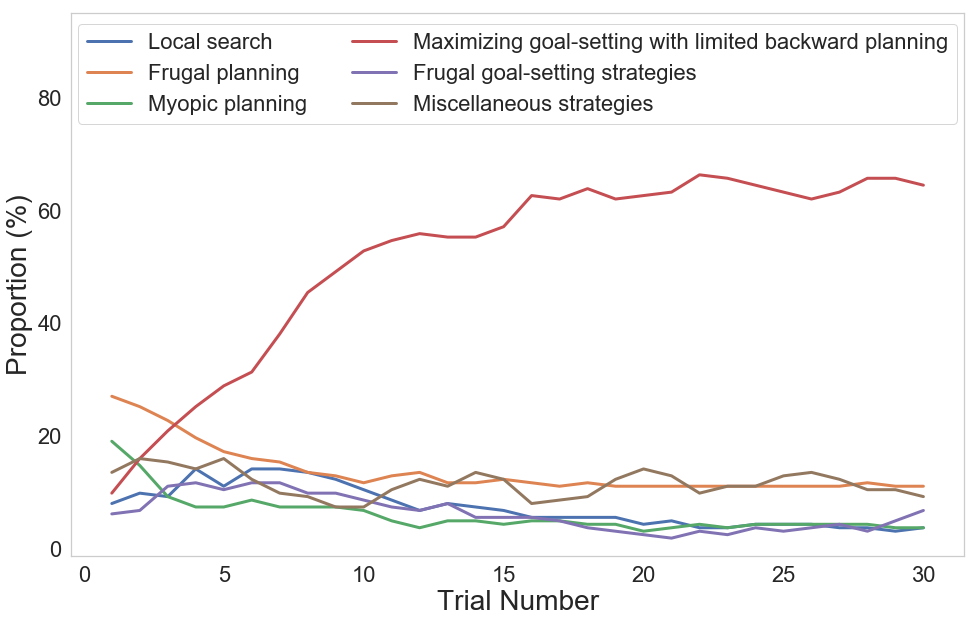

In [24]:
labels = ["Local search", "Frugal planning", "Myopic planning", "Maximizing goal-setting with limited backward planning", "Frugal goal-setting strategies", "Miscellaneous strategies"]
v1.plot_cluster_proportions(C = best_c, suffix = "total", labels=labels, combine_other=False)

### Figure 8

In [25]:
T1, T1_strategies, _ = get_E("T1.1", block='test')

In [26]:
def get_strategy_proportions(strategies):
    S = []
    for s in strategies.values():
        if type(s) == list:
            S += s
    counts = Counter(S)
    total_counts = sum(counts.values())
    counts = {k: v/total_counts for k, v in counts.items()}
    return defaultdict(int, counts)

def sort_counts(counts):
    sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_counts

Strategies for 7 not found. Skipping adding strategy data
Strategies for 28 not found. Skipping adding strategy data
Strategies for 45 not found. Skipping adding strategy data
Strategies for 46 not found. Skipping adding strategy data
Strategies for 72 not found. Skipping adding strategy data
Strategies for 89 not found. Skipping adding strategy data
Strategies for 95 not found. Skipping adding strategy data
Strategies for 97 not found. Skipping adding strategy data
Strategies for 104 not found. Skipping adding strategy data
Strategies for 107 not found. Skipping adding strategy data
Strategies for 132 not found. Skipping adding strategy data
Strategies for 143 not found. Skipping adding strategy data
Strategies for 150 not found. Skipping adding strategy data
{5, 7, 9, 10, 12, 13}


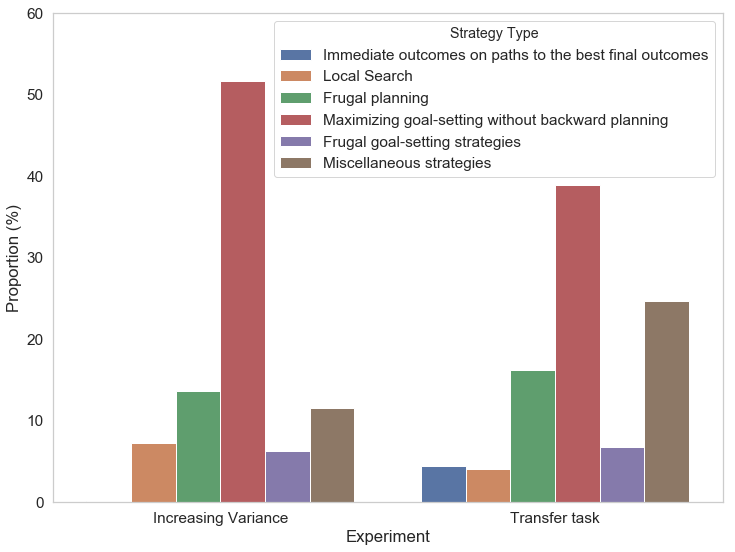

In [27]:
v1.infer_strategies(v1_strategies, show_pids=False)
T1.infer_strategies(T1_strategies, show_pids=False)
v1.init_strategy_clusters(cluster_map)
T1.init_strategy_clusters(cluster_map)
v1_proportions = get_strategy_proportions(v1.participant_clusters)
T1_proportions = get_strategy_proportions(T1.participant_clusters)
v1_cluster_counts = sort_counts(v1_proportions)
T1_cluster_counts = sort_counts(T1_proportions)

k = 5
clusters_set = set()
for counts in [v1_cluster_counts, T1_cluster_counts]:
    for p in counts[:k]:
        clusters_set.add(p[0])
print(clusters_set)

cluster_list = [12, 5, 7, 9, 10, 13]
reward_structures = ['Increasing Variance', 'Transfer task']
reward_structure_counts = [v1_proportions, T1_proportions]
data = []
columns = ['Experiment', 'Strategy Type', 'Proportion (%)']
cluster_labels = ["Immediate outcomes on paths to the best final outcomes", "Local Search", "Frugal planning", "Maximizing goal-setting without backward planning", "Frugal goal-setting strategies", "Miscellaneous strategies"]
for i in range(len(reward_structures)):
    t_prop = 0
    for j, cluster in enumerate(cluster_list):
        data.append([reward_structures[i], cluster_labels[j], reward_structure_counts[i][cluster]*100])
        t_prop += reward_structure_counts[i][cluster]
df = pd.DataFrame(data, columns=columns)
plt.figure(figsize=(12, 9))
sns.barplot(x = 'Experiment', y='Proportion (%)', hue='Strategy Type', data=df)
plt.ylim(top = 60)
plt.savefig("results/cluster_transfer.pdf", bbox_inches='tight')

### Figure 11

In [28]:
trends = ["inc", "dec", "const"]
ds_validation_sequences = defaultdict(lambda: defaultdict(list))
for trend in trends:
    for decision_system_index in range(len(decision_systems)):
        for run_num in range(num_seq):
            ds_validation_sequences[decision_system_index][trend].append(pickle_load(f"results/decision_system_validation/{decision_system_index}_{trend}_{run_num}.pkl"))

(9, 6)


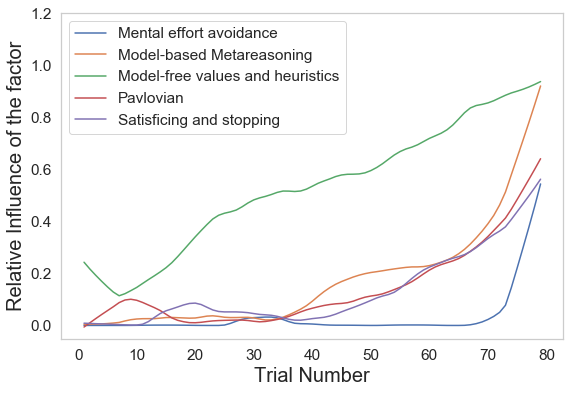

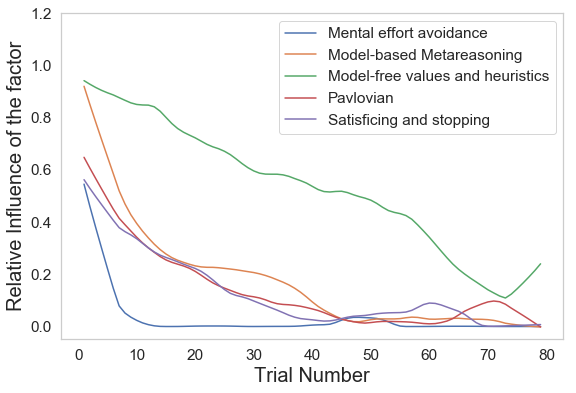

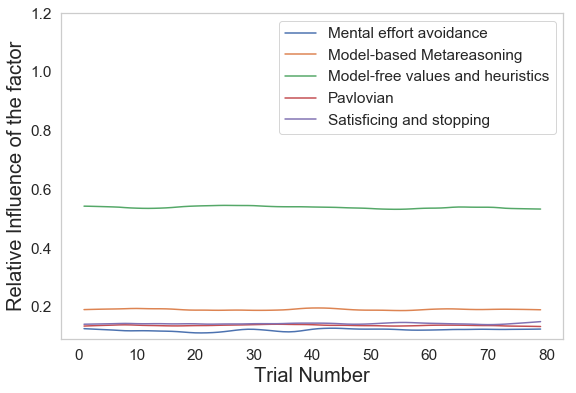

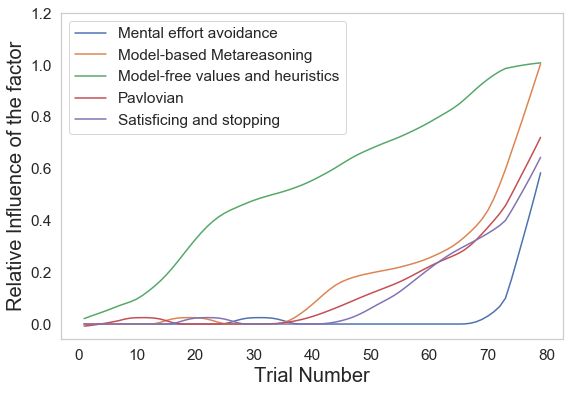

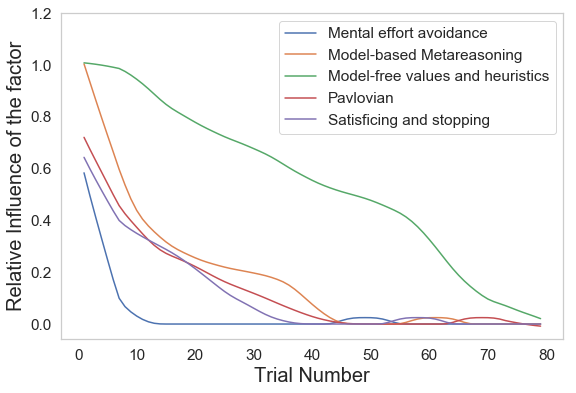

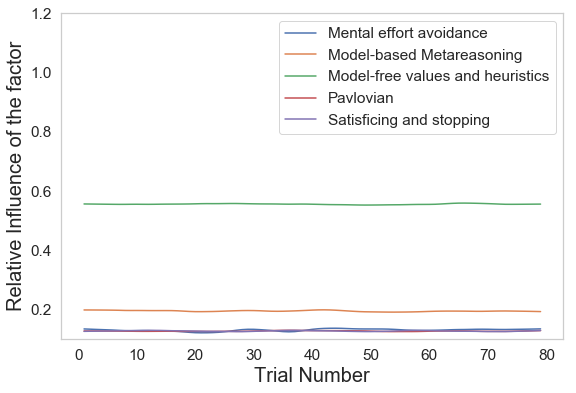

In [29]:
from learning_utils import smoothen
trend_labels = ["Increasing", "Decreasing", "Constant"]
num_seq = 500
num_decision_systems = len(decision_systems)
trend_inferred = defaultdict(lambda: defaultdict(list))
trend_actual = defaultdict(lambda: defaultdict(list))
for trend in trends:
    for decision_system_index in range(len(decision_systems)):
        for run_num in range(num_seq):
            inferred, actual = ds_validation_sequences[decision_system_index][trend][run_num]
            ds_validation_sequences[decision_system_index][trend].append((inferred, actual))
            inferred_props = [DS_proportions[s-1][decision_system_index] for s in inferred]
            actual_props = [DS_proportions[s-1][decision_system_index] for s in actual]
            trend_inferred[trend][decision_systems[decision_system_index]].append(inferred_props)
            trend_actual[trend][decision_systems[decision_system_index]].append(actual_props)
for trend in trends:
    for decision_system in decision_systems:
        trend_inferred[trend][decision_system] = np.mean(trend_inferred[trend][decision_system], axis = 0)
        trend_actual[trend][decision_system] = np.mean(trend_actual[trend][decision_system], axis = 0)
        
decision_system_labels = ["Mental effort avoidance", "Model-based Metareasoning", "Model-free values and heuristics",
                                "Pavlovian", "Satisficing and stopping"]
learning_utils.create_dir("results/decision_system_validation_plots")
figure_size = (9, 6)
for trend_index, trend in enumerate(trends):
    plt.figure(figsize = figure_size)
    for index, decision_system in enumerate(decision_systems):
        y = smoothen(trend_inferred[trend][decision_system])
        plt.plot(range(1, len(y) + 1), y, label = decision_system_labels[index])
    plt.xlabel("Trial Number", fontsize=20)
    plt.ylabel("Relative Influence of the factor", fontsize=20)
    plt.ylim(top = 1.2)
    plt.legend()
    plt.savefig(f"results/decision_system_validation_plots/{trend}_inferred.pdf", bbox_inches='tight')
print(figure_size)
for trend_index, trend in enumerate(trends):
    plt.figure(figsize = figure_size)
    for index, decision_system in enumerate(decision_systems):
        y = smoothen(trend_actual[trend][decision_system])
        plt.plot(range(1, len(y) + 1), y, label = decision_system_labels[index])
    plt.xlabel("Trial Number", fontsize=20)
    plt.ylabel("Relative Influence of the factor", fontsize=20)
    plt.ylim(top = 1.2)
    plt.legend()
    plt.savefig(f"results/decision_system_validation_plots/{trend}_actual.pdf", bbox_inches='tight')

### Figure 12

Metacognitive FB 0.01575757575757576
Metacognitive FB 0.5781818181818181
Action FB 0.1518518518518519
Action FB 0.23518518518518522
No FB 0.13950617283950617
No FB 0.30925925925925923


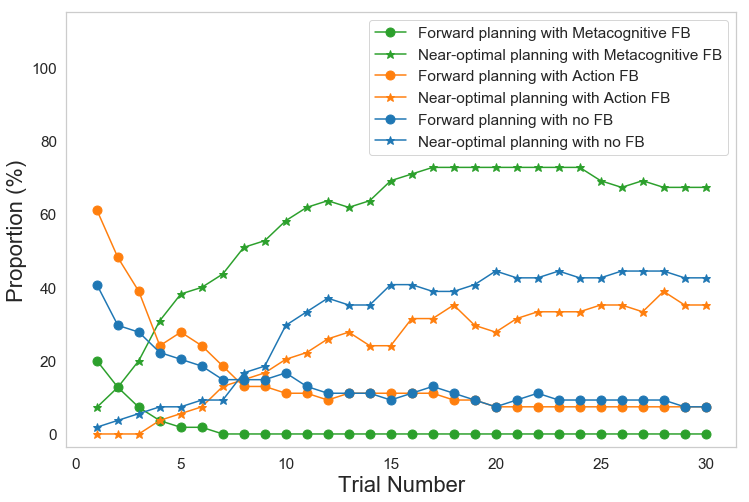

In [30]:
import matplotlib
forward_planning_strategies = [3, 10, 82, 5, 36, 37, 54, 79, 22, 23, 32, 33, 53, 64, 65, 69, 70, 80, 28, 34]
goal_setting_strategies = [21]
conditions = ['Metacognitive FB', 'Action FB', 'No FB']
markers = ["*", "o"]
forward_labels = ["Forward planning with Metacognitive FB", "Forward planning with Action FB", "Forward planning with no FB"]
goal_labels = ["Near-optimal planning with Metacognitive FB", "Near-optimal planning with Action FB", "Near-optimal planning with no FB"]
cmap = matplotlib.cm.get_cmap('tab10')
colors = [cmap(2), cmap(1), cmap(0)]
forward_freqs = {}
goal_setting_freqs = {}
no_planning_freqs = {}
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    s_props = exp.get_strategy_proportions(trial_wise=True)
    forward_freqs[conditions[i]] = np.sum([[s_props[t].get(s, 0) for t in sorted(s_props.keys())] for s in forward_planning_strategies], axis=0)
    goal_setting_freqs[conditions[i]] = np.sum([[s_props[t].get(s, 0) for t in sorted(s_props.keys())] for s in goal_setting_strategies], axis=0)
    print(conditions[i], np.mean(forward_freqs[conditions[i]]))
    print(conditions[i], np.mean(goal_setting_freqs[conditions[i]]))
plt.figure(figsize=(12, 8))
for c, condition in enumerate(conditions):
    plt.plot(range(1, 31), forward_freqs[condition]*100, marker = markers[1], color = colors[c], label=forward_labels[c], markersize=9)
    plt.plot(range(1, 31), goal_setting_freqs[condition]*100, marker = markers[0], color = colors[c], label=goal_labels[c], markersize=9)
plt.legend()
plt.ylim(top=115)
plt.xlabel("Trial Number", fontsize=22)
plt.ylabel("Proportion (%)", fontsize=22)
plt.savefig("results/planning_conditions.pdf", bbox_inches='tight')

### Figure 13

Strategies for 0 not found. Skipping adding strategy data
Strategies for 1 not found. Skipping adding strategy data
Strategies for 2 not found. Skipping adding strategy data
Strategies for 3 not found. Skipping adding strategy data
Strategies for 5 not found. Skipping adding strategy data
Strategies for 6 not found. Skipping adding strategy data
Strategies for 7 not found. Skipping adding strategy data
Strategies for 8 not found. Skipping adding strategy data
Strategies for 9 not found. Skipping adding strategy data
Strategies for 11 not found. Skipping adding strategy data
Strategies for 12 not found. Skipping adding strategy data
Strategies for 14 not found. Skipping adding strategy data
Strategies for 15 not found. Skipping adding strategy data
Strategies for 16 not found. Skipping adding strategy data
Strategies for 17 not found. Skipping adding strategy data
Strategies for 18 not found. Skipping adding strategy data
Strategies for 19 not found. Skipping adding strategy data
Strate

FileNotFoundError: [Errno 2] No such file or directory: '../results/v1.0_decision_plots_meta.pdf'

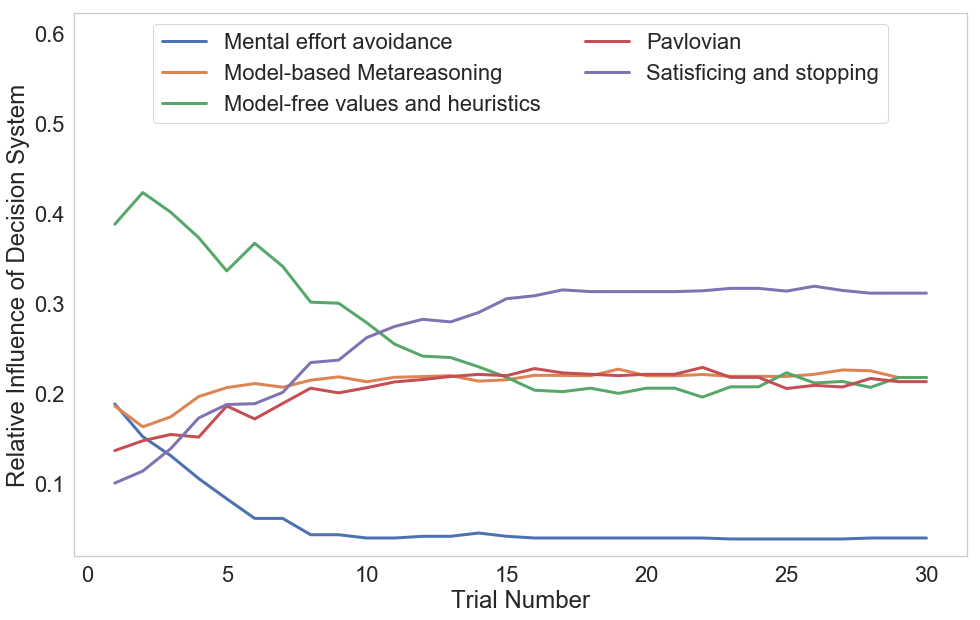

In [31]:
suffixes = ["meta", "action", "none"]
exp_s = [v1_meta_strategies, v1_action_strategies, v1_nofb_strategies]
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    exp.infer_strategies(precomputed_strategies = exp_s[i], show_pids=False)
    exp.init_decision_system_properties(decision_systems, W_DS, DS_proportions)
    exp.plot_average_ds(suffix = suffixes[i])
    mean_dsw = exp.get_mean_DSW()

## Table 1

In [32]:
strategy_participant_count = defaultdict(int)
strategy_trial_count = defaultdict(int)
strategy_type_participant_count = defaultdict(int)
strategy_type_trial_count = defaultdict(int)
participant_strategy_trial_count = defaultdict(int)
participant_strategy_type_trial_count = defaultdict(int)

total_p = 0
total_trials = 0
strategies = v1_strategies
num_trials = 30

for k, v in strategies.items():
    total_p += 1
    total_trials += len(v)
    for strategy in range(1, 90):
        if strategy in v:
            strategy_participant_count[strategy] += 1
            participant_strategy_trial_count[strategy] += Counter(v)[strategy]
            for s in v:
                if s==strategy:
                    strategy_trial_count[strategy] += 1

for strategy_type in range(1, 14):
    for k,v in strategies.items():
        strategy_types = [cluster_map[s] for s in v]
        if strategy_type in strategy_types:
            strategy_type_participant_count[strategy_type] += 1
            participant_strategy_type_trial_count[strategy_type] += Counter(strategy_types)[strategy_type]
        for st in strategy_types:
            if st == strategy_type:
                strategy_type_trial_count[strategy_type] += 1

participant_strategy_trial_count = {k: np.round(v/(strategy_participant_count[k]*num_trials), 3) for k,v in participant_strategy_trial_count.items()}
participant_strategy_type_trial_count = {k: np.round(v/(strategy_type_participant_count[k]*num_trials), 3) for k,v in participant_strategy_type_trial_count.items()}

strategy_participant_count = {k: np.round(v/total_p, 3) for k,v in strategy_participant_count.items()}
strategy_type_participant_count = {k: np.round(v/total_p, 3) for k,v in strategy_type_participant_count.items()}

strategy_trial_count = {k: np.round(v/total_trials, 3) for k,v in strategy_trial_count.items()}
strategy_type_trial_count = {k: np.round(v/total_trials, 3) for k,v in strategy_type_trial_count.items()}

In [33]:
for strategy_type, tc in sorted(strategy_type_trial_count.items(), key=operator.itemgetter(1), reverse=True)[:6]:
    print(cluster_names[strategy_type], tc, strategy_type_participant_count[strategy_type], participant_strategy_type_trial_count[strategy_type])
    for strategy, v in sorted(strategy_trial_count.items(), key=operator.itemgetter(1), reverse=True)[:10]:
        if cluster_map[strategy] == strategy_type:
            print(strategy, v, strategy_participant_count[strategy], participant_strategy_trial_count[strategy])

Maximizing goal-setting with limited backward planning 0.504 0.688 0.697
21 0.366 0.551 0.631
57 0.063 0.176 0.338
43 0.022 0.102 0.206
Frugal planning 0.148 0.341 0.412
30 0.132 0.261 0.478
Miscellaneous strategies 0.113 0.438 0.246
42 0.022 0.114 0.18
Local search 0.074 0.273 0.258
31 0.036 0.142 0.243
11 0.021 0.08 0.25
Myopic planning 0.065 0.29 0.212
22 0.021 0.097 0.204
23 0.021 0.091 0.223
Frugal goal-setting strategies 0.061 0.29 0.2
26 0.021 0.08 0.245


## Table 3

In [34]:
nofb_trs, nofb_sorted_counts = get_trajectories(v1_nofb)
c_nofb_trs, c_nofb_sorted_counts = get_cluster_trajectories(v1_nofb)
meta_trs, meta_sorted_counts = get_trajectories(v1_meta)
c_meta_trs, c_meta_sorted_counts = get_cluster_trajectories(v1_meta)
action_trs, action_sorted_counts = get_trajectories(v1_action)
c_action_trs, c_action_sorted_counts = get_cluster_trajectories(v1_action)

def print_info(props):
    for p in props[:5]:
        print(tuple(cluster_names[st] for st in p[0]), p[1])

print("No FB")
props = print_props(c_nofb_sorted_counts, p=False)
print_info(props)
print("Meta FB")
props = print_props(c_meta_sorted_counts, p=False)
print_info(props)
print("Action FB")
props = print_props(c_action_sorted_counts, p=False)
print_info(props)

No FB
('Frugal planning',) 0.07
('Myopic planning', 'Local search', 'Maximizing goal-setting with limited backward planning') 0.06
('Maximizing goal-setting with limited backward planning',) 0.06
('Forward planning strategies similar to Best First Search', 'Maximizing goal-setting with limited backward planning') 0.04
('Miscellaneous strategies', 'Maximizing goal-setting with limited backward planning') 0.04
Meta FB
('Maximizing goal-setting with limited backward planning',) 0.22
('Miscellaneous strategies', 'Maximizing goal-setting with limited backward planning') 0.16
('Frugal goal-setting strategies', 'Maximizing goal-setting with limited backward planning') 0.07
('Frugal planning', 'Frugal goal-setting strategies', 'Maximizing goal-setting with limited backward planning') 0.07
('Frugal planning', 'Maximizing goal-setting with limited backward planning') 0.05
Action FB
('Frugal planning',) 0.11
('Myopic planning',) 0.04
('Myopic planning', 'Frugal planning', 'Myopic planning', 'Frug

## Table 4

In [35]:
num_simulations = 100000
strategy_scores_dict = defaultdict(lambda: defaultdict())
strategy_mean_scores_dict = defaultdict(lambda: defaultdict())
for exp_num in ["v1.0", "c1.1", "T1.1", "c2.1_dec"]:
    for strategy_num in range(89):
        scores, _ = pickle_load(f"results/strategy_scores_non_optimal/{exp_num}_{strategy_num}.pkl")
        strategy_mean_scores_dict[exp_num][strategy_num+1] = np.mean(scores)
        strategy_scores_dict[exp_num][strategy_num + 1] = scores

In [36]:
v1_test, v1_test_strategies, _ = get_E("v1.0", block="test")

In [37]:
def get_top_k(counts, k=4):
    S = {c[0] for c in counts[:k]}
    return S
    
def print_strategy_scores(Sf, exp_num):
    sorted_freqs = sorted(Sf.items(), key=lambda x:x[1], reverse=True)
    max_score = max([strategy_mean_scores_dict[exp_num][s[0]] for s in sorted_freqs])
    min_score = min([strategy_mean_scores_dict[exp_num][s[0]] for s in sorted_freqs])
    for p in sorted_freqs:
        if p[1] >= 0.0295:
            k = strategy_mean_scores_dict[exp_num][p[0]]
            max_min_norm = np.round((k-min_score)/(max_score-min_score), 2)
            print(f"Strategy: {p[0]}, Strategy Freq: {np.round(p[1], 3)}, Score: {max_min_norm}")
        
c1_counts = get_strategy_proportions(c1_strategies)
c2_inc_counts = get_strategy_proportions(c2_inc_strategies)
c2_dec_counts = get_strategy_proportions(c2_dec_strategies)
transfer_counts = get_strategy_proportions(T1_strategies)
v1_counts = get_strategy_proportions(v1_test_strategies)

print("Increasing variance - 3 steps")
print_strategy_scores(v1_counts, "v1.0")
print("\n")

print("Increasing variance - 5 steps")
print_strategy_scores(transfer_counts, "T1.1")
print("\n")

print("Decreasing variance")
print_strategy_scores(c2_dec_counts, "c2.1_dec")
print("\n")

print("Constant variance")
print_strategy_scores(c1_counts, "c1.1")
print("\n")

Increasing variance - 3 steps
Strategy: 21, Strategy Freq: 0.451, Score: 1.0
Strategy: 57, Strategy Freq: 0.116, Score: 0.93
Strategy: 30, Strategy Freq: 0.106, Score: 0.13


Increasing variance - 5 steps
Strategy: 21, Strategy Freq: 0.208, Score: 1.0
Strategy: 30, Strategy Freq: 0.162, Score: 0.28
Strategy: 63, Strategy Freq: 0.124, Score: 0.97
Strategy: 87, Strategy Freq: 0.116, Score: 0.92
Strategy: 88, Strategy Freq: 0.066, Score: 0.97
Strategy: 51, Strategy Freq: 0.045, Score: 0.99


Decreasing variance
Strategy: 65, Strategy Freq: 0.327, Score: 0.97
Strategy: 37, Strategy Freq: 0.267, Score: 0.94
Strategy: 30, Strategy Freq: 0.125, Score: 0.0
Strategy: 33, Strategy Freq: 0.108, Score: 0.96
Strategy: 79, Strategy Freq: 0.054, Score: 0.93
Strategy: 23, Strategy Freq: 0.053, Score: 1.0


Constant variance
Strategy: 22, Strategy Freq: 0.179, Score: 0.81
Strategy: 37, Strategy Freq: 0.144, Score: 0.91
Strategy: 70, Strategy Freq: 0.102, Score: 0.81
Strategy: 5, Strategy Freq: 0.064, S

## Table 5

In [38]:
strategy_type_scores = defaultdict(lambda: defaultdict(list))
strategy_type_mean_scores = defaultdict(lambda: defaultdict(list))
exp_nums = ["v1.0", "c1.1", "T1.1", "c2.1_dec"]
for strategy in strategy_space:
    for exp_num in exp_nums:
        strategy_type_scores[exp_num][cluster_map[strategy]] += (strategy_scores_dict[exp_num][strategy])
        strategy_type_mean_scores[exp_num][cluster_map[strategy]].append(strategy_mean_scores_dict[exp_num][strategy])

for exp_num in exp_nums:
    for k in strategy_type_scores[exp_num].keys():
        strategy_type_mean_scores[exp_num][k] = np.mean(strategy_type_mean_scores[exp_num][k])

In [39]:
def make_strategy_types(S):
    return [cluster_map[s] for s in S]

def print_scores(Sf, exp_num):
    sorted_freqs = sorted(Sf.items(), key=lambda x:x[1], reverse=True)
    max_score = max([strategy_type_mean_scores[exp_num][s[0]] for s in sorted_freqs])
    min_score = min([strategy_type_mean_scores[exp_num][s[0]] for s in sorted_freqs])
    print(max_score, min_score)
    for p in sorted_freqs:
        if p[1] >= 0.0295:
            k = strategy_type_mean_scores[exp_num][p[0]]
            max_min_norm = np.round((k-min_score)/(max_score-min_score), 2)
            print(f"Strategy Type: {cluster_names[p[0]]}, Strategy Freq: {np.round(p[1], 3)}, {strategy_type_mean_scores[exp_num][p[0]]}, Score: {max_min_norm}")
        
exp_nums = ["v1.0", "T1.1", "c2.1_dec", "c1.1"]

for exp_num in exp_nums:
    for k in strategy_type_scores[exp_num].keys():
        strategy_type_mean_scores[exp_num][k] = np.mean(strategy_type_mean_scores[exp_num][k])
        
c1_strategy_types = get_strategy_proportions({k: make_strategy_types(v) for k,v in c1_strategies.items()})
c2_inc_strategy_types = get_strategy_proportions({k: make_strategy_types(v) for k,v in c2_inc_strategies.items()})
c2_dec_strategy_types = get_strategy_proportions({k: make_strategy_types(v) for k,v in c2_dec_strategies.items()})
transfer_strategy_types = get_strategy_proportions({k: make_strategy_types(v) for k, v in T1_strategies.items()})
v1_strategy_types = get_strategy_proportions({k: make_strategy_types(v) for k, v in v1_test_strategies.items()})

print("Increasing variance - 3 steps")
print_scores(v1_strategy_types, "v1.0")
print("\n")

print("Increasing variance - 5 steps")
print_scores(transfer_strategy_types, "T1.1")
print("\n")

print("Decreasing variance")
print_scores(c2_dec_strategy_types, "c2.1_dec")
print("\n")

print("Constant variance")
print_scores(c1_strategy_types, "c1.1")
print("\n")

Increasing variance - 3 steps
36.65242500000001 6.35445
Strategy Type: Maximizing goal-setting with limited backward planning, Strategy Freq: 0.629, 36.65242500000001, Score: 1.0
Strategy Type: Frugal planning, Strategy Freq: 0.11, 6.35445, Score: 0.0
Strategy Type: Miscellaneous strategies, Strategy Freq: 0.102, 30.99146705882353, Score: 0.81
Strategy Type: Local search, Strategy Freq: 0.055, 34.161731666666675, Score: 0.92
Strategy Type: Myopic planning, Strategy Freq: 0.047, 18.735749000000002, Score: 0.41
Strategy Type: Frugal goal-setting strategies, Strategy Freq: 0.038, 29.012849, Score: 0.75


Increasing variance - 5 steps
42.542487183425884 7.298093497016318
Strategy Type: Maximizing goal-setting with limited backward planning, Strategy Freq: 0.389, 37.766256131032854, Score: 0.86
Strategy Type: Miscellaneous strategies, Strategy Freq: 0.246, 29.36951542020864, Score: 0.63
Strategy Type: Frugal planning, Strategy Freq: 0.162, 7.298093497016318, Score: 0.0
Strategy Type: Frugal

## Tests

In [40]:
strategy_si_map = pickle_load("data/strategy_si_map.pkl")
si_strategy_map = pickle_load("data/si_strategy_map.pkl")
si_strategy_space = [si_strategy_map[s] for s in range(1, 80)]

## Appendix tables

In [41]:
def gen_table(exp):
    data = []
    xs = []
    for strategy in si_strategy_space:
        path = f"results/strategy_likelihoods/{strategy}"
        if exp == "transfer":
            path += "_transfer"
        L = pickle_load(path+".pkl")
        sorted_L = np.sort(L)[:, ::-1]
        median_best = np.median(np.exp(sorted_L[:, 0] - sorted_L[:,1]))
        max_L = np.max(L, axis=1)
        diff_L = L - max_L[:, None]
        ratio_L = np.exp(diff_L)
        mean_ratio_L = np.mean(ratio_L, axis=0)
        mean_ratio_L = [np.round(l, 3) for l in mean_ratio_L]
        data.append([strategy_si_map[strategy]] + [median_best] + sorted(mean_ratio_L)[-10:][::-1])
        x = sorted(mean_ratio_L)[-10:][::-1]
        if x[1] != 0:
            xs.append(x[0]/x[1])
    df = pd.DataFrame(data, columns = ["Strategy", "LR"] + list(range(1, 11)))
    df = df.set_index("Strategy")
    pd.reset_option('display.float_format')
    print(np.median(xs))
    return df

In [42]:
v1_latex = gen_table("v1.0")
transfer_latex = gen_table("transfer")

4.128630705394191
7.8125
